In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import corrcoef
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.api import GLS
from numpy import cov
from scipy.stats import spearmanr

In [2]:
import sys
sys.path.insert(0, '../../scripts/')

In [3]:
from common_funcs import common_index, save_list

In [4]:
import matplotlib
font = {
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
species = !ls ../../data/preprocessed/gex_counts_by_sample/

In [6]:
pairs_use = [('human', 'macaque'), ('human', 'marmoset'), ('human', 'mouse'), ('macaque', 'marmoset'), ('macaque', 'mouse'), ('marmoset', 'mouse')]

In [7]:
clust_measures = {specie : pd.read_csv('../../data/processed/gex_for_gls/log2cpm/{}_clusters_orthologous_counts.txt'.format(specie),
                                                            sep = '\t').set_index('human_gene') for specie in species}

In [8]:
orthologs = pd.read_csv('../../data/ref/four_species_orthologous_protein_coding_genes_1to1_filtered.txt', sep='\t')

In [9]:
def common_ortholog(df, specie):
    genes = df.index.values
    new = orthologs.set_index(specie + '_gene').loc[genes]
    new_ids = new.reset_index()['human_gene']
    df.index = new_ids
    return df    

# example covariance

In [10]:
check_specie = 'human'

In [11]:
check = cov(clust_measures[check_specie][clust_measures[check_specie].columns].values.T)

Text(0.5, 1.0, 'covariance among cell types logcpm')

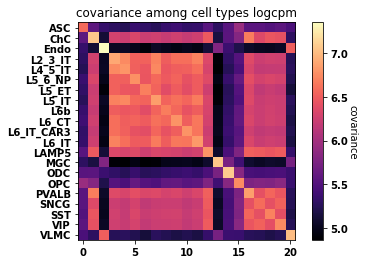

In [12]:
im = plt.imshow(check, cmap ='magma')
ticks = plt.yticks(np.arange(21), labels = clust_measures[check_specie].columns)
cbar = plt.colorbar(im)
cbar.set_label('covariance',
                       rotation=270,
                       labelpad=10)
plt.title('covariance among cell types logcpm')

In [13]:
from scipy.stats import pearsonr, spearmanr
!mkdir -p ../../data/outputs/gex_gls_results/

# Calculate GLS

In [14]:
for pair in pairs_use:
    spec1, spec2 = pair
    df1 = clust_measures[spec1]
    df2 = clust_measures[spec2]
    # threshold expression
    df1_ids = df1.loc[((df1 > 1).sum(axis=1) > 1) & ((df2 > 0).sum(axis=1) > 1)].index.values
    df2_ids = df2.loc[((df2 > 1).sum(axis=1) > 1) & ((df1 > 0).sum(axis=1) > 1)].index.values
    
    use_ids = np.unique(np.concatenate([df1_ids, df2_ids]))
    df1 = df1.loc[use_ids]
    df2 = df2.loc[use_ids]
    df1, df2 = common_index(df1, df2)
    print(df1.shape, df2.shape)
    n_gene = df1.shape[0]
    cov_use = cov(df1.values.T)+cov(df2.values.T)/2
    r_square = [None] * n_gene
    param = [None] * n_gene
    p_vals = [None] * n_gene
    t_vals = [None] * n_gene
    corr = [None] * n_gene
    corr_p = [None] * n_gene
    pear_corr =[None] * n_gene
    pear_p = [None] * n_gene
    for idx in range(n_gene):
        model = GLS(df1.iloc[idx].values, df2.iloc[idx].values, sigma=cov_use)
        res = model.fit()
        r_square[idx] = res.rsquared
        p_vals[idx] = res.pvalues[0]
        param[idx] = res.params[0]
        t_vals[idx] = res.t_test([1]).tvalue[0][0]
        # compare to correlation
        corr_, corr_p_ = spearmanr(df1.iloc[idx].values, df2.iloc[idx].values)
        corr[idx] = corr_
        corr_p[idx] = corr_p_ 
        pear_c, pear_p_ = pearsonr(df1.iloc[idx].values, df2.iloc[idx].values)
        pear_corr[idx] = pear_c
        pear_p[idx] = pear_p_
    sig, fdr = fdrcorrection(p_vals, alpha=.05, method='n')
    sig_corr, fdr_corr = fdrcorrection(corr_p, alpha=.05, method='n')
    sig_pearson, fdr_pear = fdrcorrection(pear_p, alpha=.05, method='n')
    
    print(np.sum(fdr < .05), spec1, spec2)
    print(sig_corr.sum())
    df_res = pd.DataFrame(np.array([r_square, param, p_vals, t_vals, fdr, corr, fdr_corr, pear_corr, fdr_pear]).T,
                        index=df1.index,
                        columns=['r_square', 'coeff', 'p_val', 't_val', 'fdr', 'corr', 'fdr_corr', 'pear_corr', 'fdr_pear'])
    df_res.to_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')

(14260, 21) (14260, 21)
8168 human macaque
3956
(14100, 21) (14100, 21)
6609 human marmoset
2927
(14039, 21) (14039, 21)
4074 human mouse
1326
(14219, 21) (14219, 21)
7127 macaque marmoset
4006
(14118, 21) (14118, 21)
4364 macaque mouse
1885
(13896, 21) (13896, 21)
4479 marmoset mouse
1639


# gls vs corr

8168 3956
6609 2927
4074 1326
7127 4006
4364 1885
4479 1639


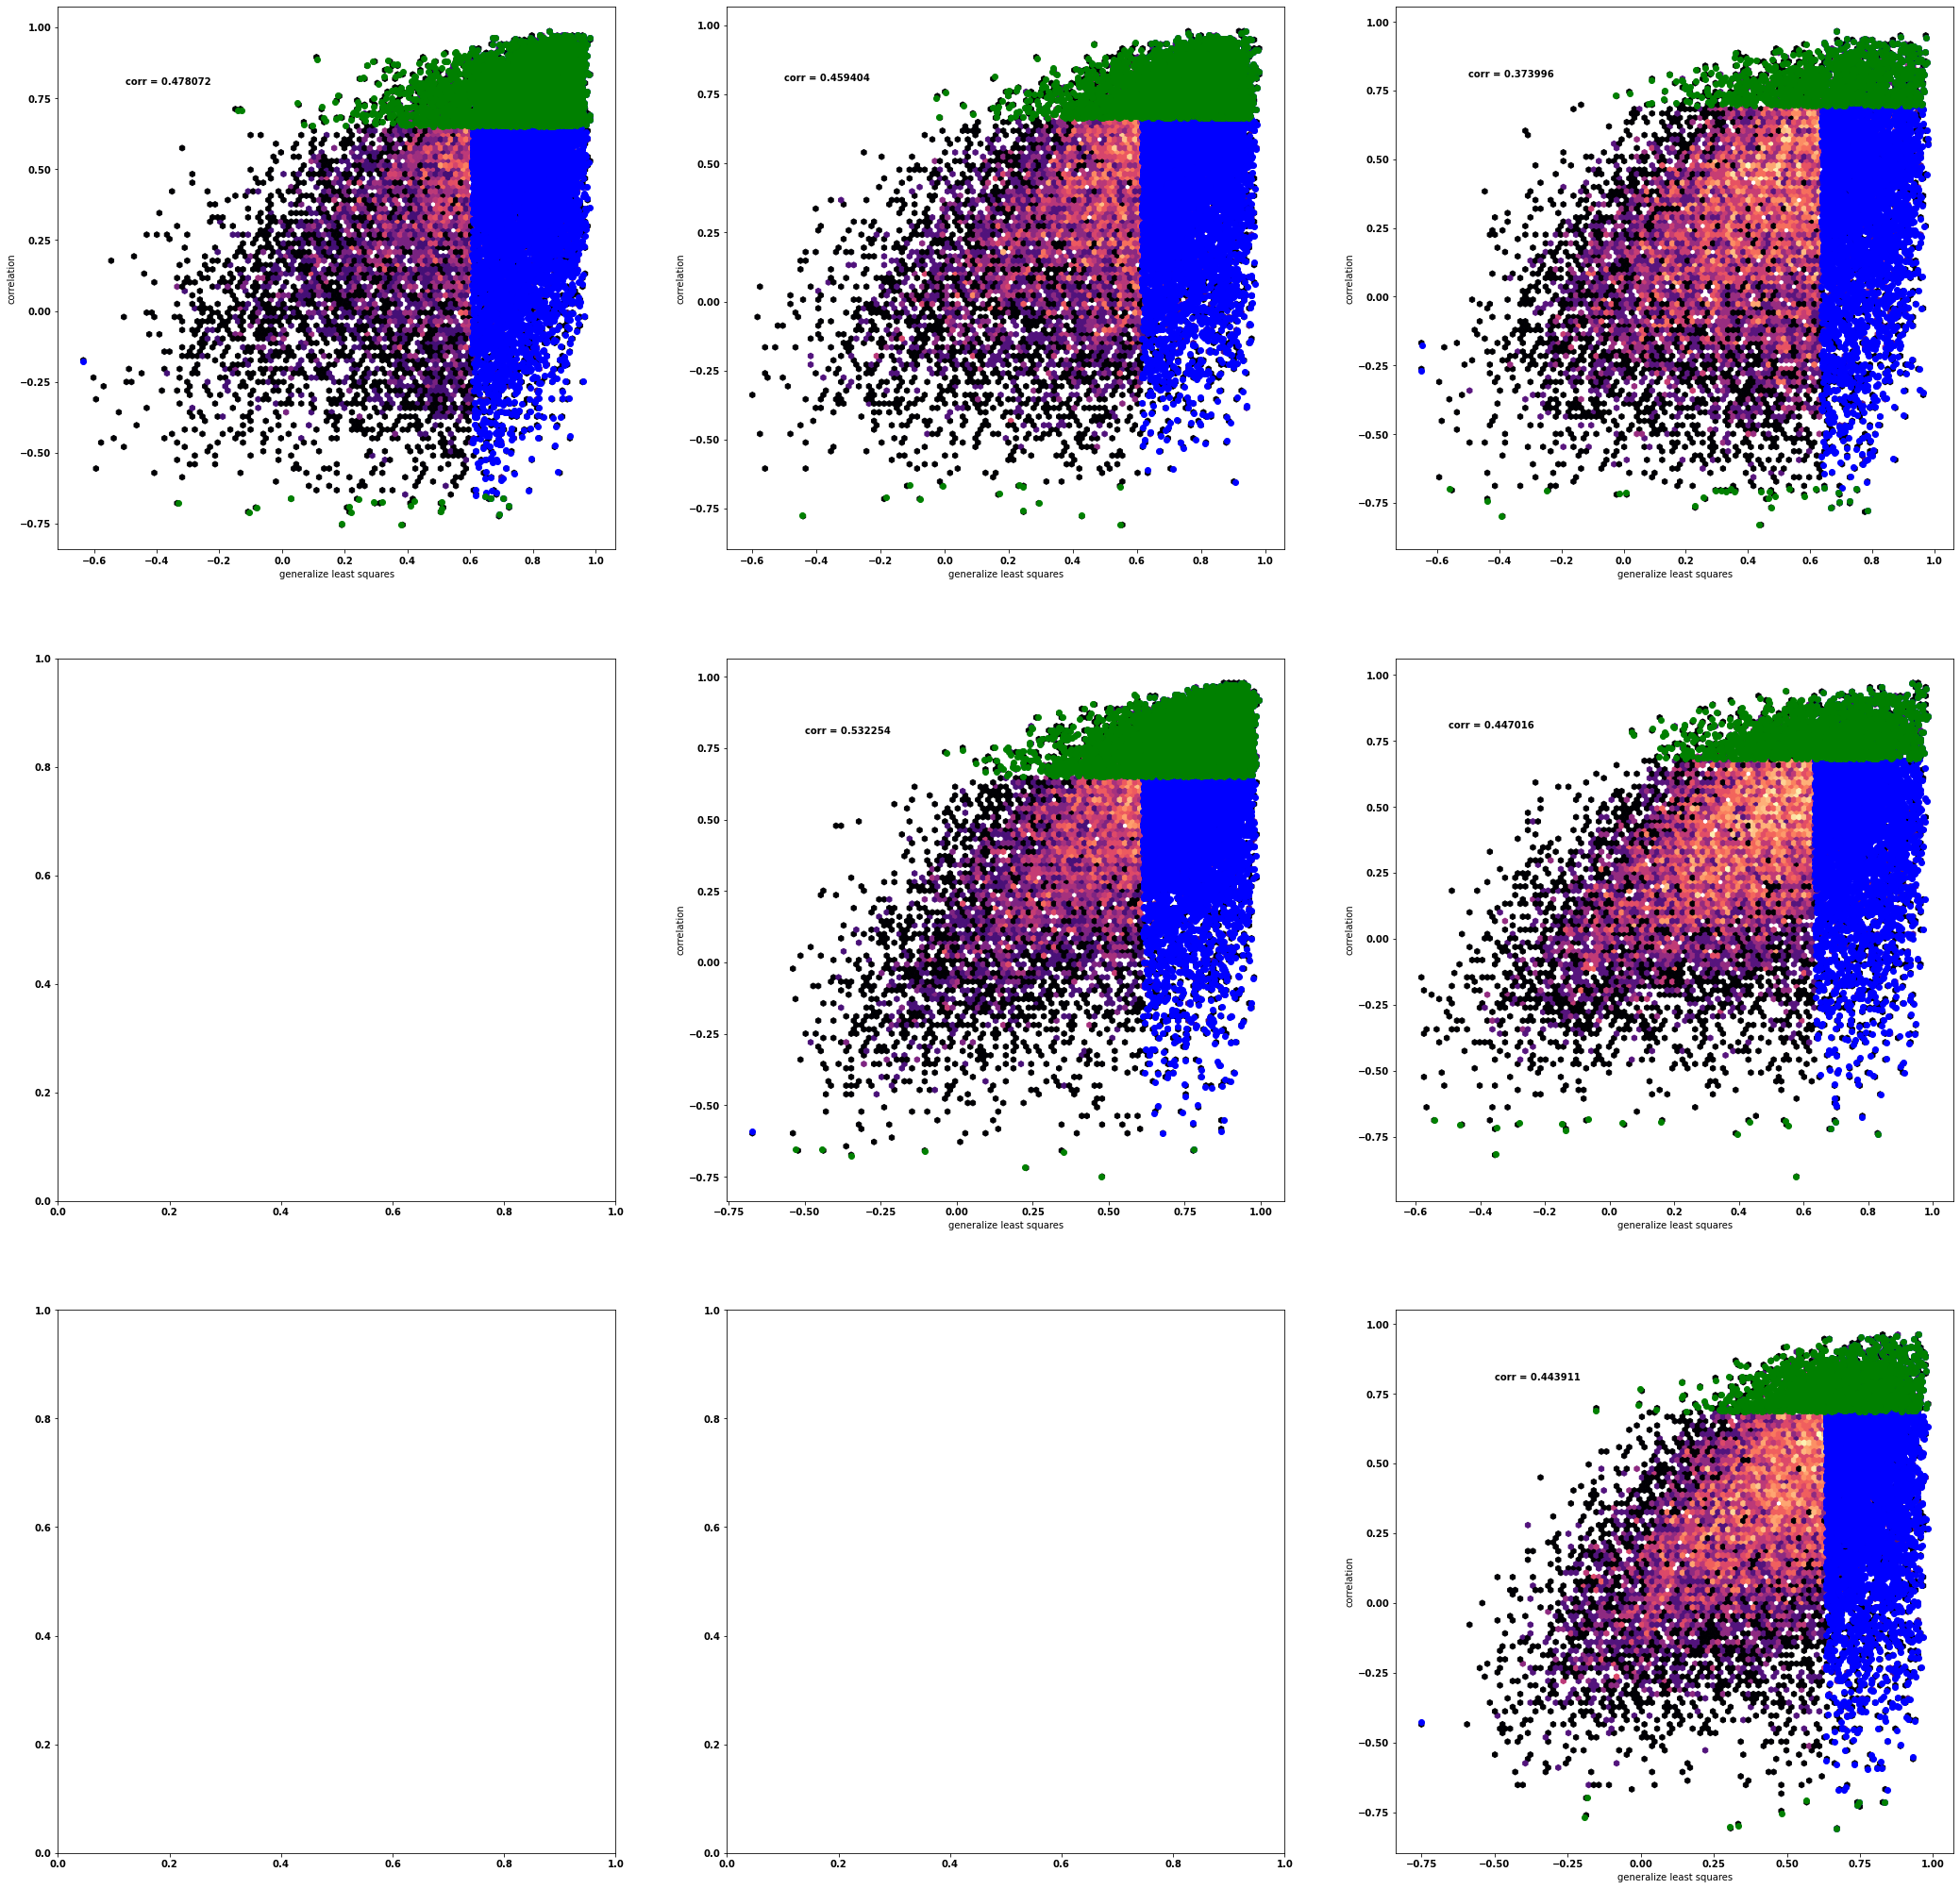

In [15]:
all_stats = {}
gene_gls = []
gene_corr = []
p_gls = []
slcs = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20


a_cons = []
p_cons = []
nh_cons = []
nh_bg = []

a_bg = []
p_bg = []
axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    slcs.append(stats.loc[stats.human_gene == 'RYR3'])
    all_stats['{}_{}'.format(spec1, spec2)] = stats
    # slcs['{}_{}'.format(spec1, spec2)] = stats.loc[stats.human_gene == 'SLC17A7']
    
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05
    sig_corr = stats['fdr_corr'] < .05
    a_cons.append(stats.loc[stats['fdr'] < .05].human_gene.values)
    a_bg.append(stats.human_gene.values)
    if 'mouse' not in pair:
        p_cons.append(stats.loc[stats['fdr'] < .05].human_gene.values)
        p_bg.append(stats.human_gene.values)
    if 'human' not in pair:
        nh_cons.append(stats.loc[stats['fdr'] < .05].human_gene.values)
        nh_bg.append(stats.human_gene.values)
    
    gene_gls.append(stats.loc[stats['fdr'] < .001/6].human_gene.values)
    gene_corr.append(stats.loc[stats['fdr_corr'] < .05].human_gene.values)
    if 'mouse' not in pair:
        p_gls.append(stats.loc[sig_gls].human_gene.values)
    ax.text(-.5, .8, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [16]:
from common_funcs import list_intersection

In [29]:
save_list('../../data/outputs/conserved_genes/all_conserved.txt', list_intersection(a_cons))

16775

In [30]:
save_list('../../data/outputs/conserved_genes/all_conserved_bg.txt', list_intersection(a_bg))

83778

In [31]:
save_list('../../data/outputs/conserved_genes/primate_conserved.txt',
          np.setdiff1d(list_intersection(p_cons),
                      list_intersection(a_cons)))

16688

In [32]:
save_list('../../data/outputs/conserved_genes/primate_conserved_bg.txt', list_intersection(p_bg))

86663